In [1]:
# core packages for data analysis
import numpy as np, pandas as pd
import pymc3 as pm
import scipy as sp

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [2]:
from matplotlib import pyplot as plt # core graphing
import seaborn as sns # pretty graphing
import bokeh # interactive graphing
from bokeh.plotting import figure, output_notebook, show
from bokeh.resources import INLINE
output_notebook(resources=INLINE)
%matplotlib inline

Loading BokehJS ...

David Diaz

# Final Exam

#### Your objective is to determine if daily ambient air pollution levels are associated with cardiovascular mortality. To do so, you will look at data collected from Los Angeles, CA from 1987 to 1997. The variables associated with the data are listed below and the data are available in “LAdata.csv”. Please consider the following in addressing this objective – based on your findings, what is the most important air pollution predictor of death?  
#### Include a brief introduction (1 – 3 sentences), a methods section (with a written description of the model(s) fit, the modeling approach you took, implementation, diagnostics, model selection, etc.), a results, and a short discussion (3-4 sentences that interprets your findings). Tables and figures are welcome.

### Section 1 - Data Exploration

In [3]:
data = pd.read_csv('LAData.csv')

In [4]:
data.head()

,Date,Month,Day of week,season,Deaths,Temp,RelHumid,O3,SO2,NO2,CO
0,1/1/1987,1,5,1,96,57.0000,88.1250,-16.0073,2.8412,26.3063,2436.2
1,1/2/1987,1,6,1,107,57.6250,84.5625,-11.6595,1.1812,27.8281,2011.5
2,1/3/1987,1,7,1,99,58.3750,83.0625,-10.3241,1.1416,11.1614,1215.5
3,1/4/1987,1,1,1,93,54.8750,84.5625,-18.6471,-3.0086,-12.3531,-767.8
4,1/5/1987,1,2,1,97,54.6875,65.1250,-17.5291,-1.4868,-10.2597,145.7


In [5]:
data['Date'] =  pd.to_datetime(data['Date'], format='%m/%d/%Y')

In [6]:
data['Day'] = (data.Date - data.Date[0]).astype('timedelta64[D]')

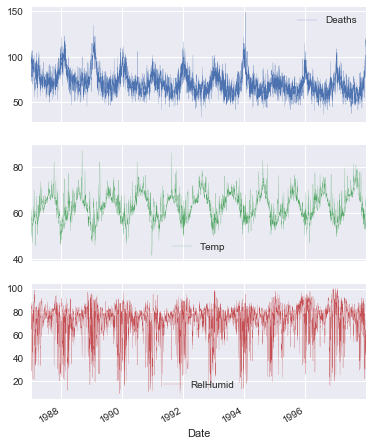

In [7]:
data.plot(x='Date', y=['Deaths', 'Temp', 'RelHumid'], linewidth=0.2, subplots=True, figsize=(6, 8));

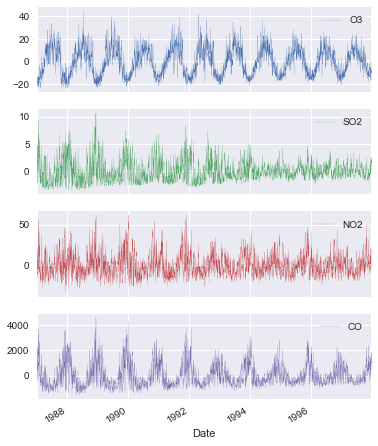

In [8]:
data.plot(x='Date', y=['O3', 'SO2', 'NO2', 'CO'], linewidth=0.2, subplots=True, figsize=(6, 8));

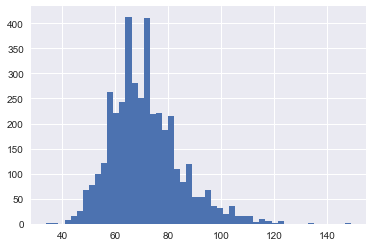

In [9]:
data.Deaths.hist(bins=50);

In [10]:
from pandas.tools.plotting import scatter_matrix

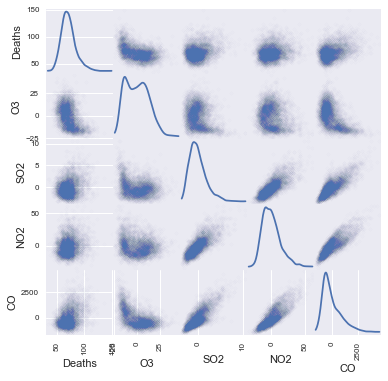

In [11]:
scatter_cols = ['Deaths', 'O3', 'SO2', 'NO2', 'CO']
scatter_matrix(data[scatter_cols], alpha=0.01, figsize=(6, 6), diagonal='kde');

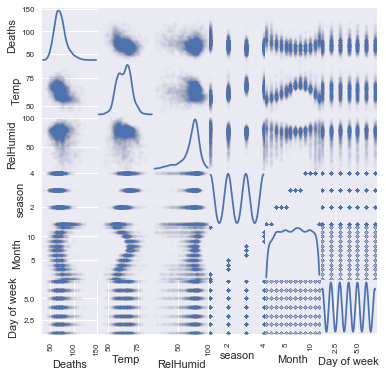

In [12]:
scatter_cols = ['Deaths', 'Temp', 'RelHumid', 'season', 'Month', 'Day of week']
scatter_matrix(data[scatter_cols], alpha=0.01, figsize=(6, 6), diagonal='kde');

### Section 2 - Modest Data Munging

To facilitate MCMC sampling, we'll transform all continuous covariates to z-scores. Temperature and Relative humidity values are still raw values, but pollutant levels came already centered with mean=0.

In [ ]:
temp_smooth = sp.interpolate.interp1d(x=data.Day, y=Temp, kind='cubic')

In [ ]:
plt.figure()
plt.scatter(x=data.Date, y=Temp)
plt.plot(x=data.Date, y=temp_smooth)

In [ ]:
Date = data.Date
Temp = data.zTemp = (data.Temp - data.Temp.mean())/data.Temp.std()
RelHum = data.zRelHum = (data.RelHumid - data.RelHumid.mean())/data.RelHumid.std()
Season = data.season
Month = data.Month
DayWeek = data['Day of week']
O3 = data.zO3 = data.O3/data.O3.std()
SO2 = data.zSO2 = data.SO2/data.SO2.std()
NO2 = data.zNO2 = data.NO2/data.NO2.std()
CO = data.zCO = data.CO/data.CO.std()
deaths = data.Deaths

In [ ]:
num_obs = len(deaths)

### Section 3 - Bayesian Modeling

$y_t \sim Poisson(\mu_t)$  
$log(\mu_t) = \beta_0 + \beta_{1,t}Temp + \beta_{2,t}RelHum + \beta_3Season + \beta_4Month + \beta_5DayofWeek + \alpha_1O_3 + \alpha_2SO_2 + \alpha_3NO_2 + \alpha_4CO$

In [ ]:
with pm.Model() as pollutant_model:
    
    # priors for unknown model parameters
    b0 = pm.Normal('b0', mu=0, sd=1000)
    b1_mu = pm.Normal('b1_mu', mu=0, sd=10)
    b1_sigma = pm.Uniform('b1_sigma', lower=0, upper=5)
    b2_mu = pm.Normal('b2_mu', mu=0, sd=10)
    b2_sigma = pm.Uniform('b2_sigma', lower=0, upper=5)
    b3 = pm.Normal('b3', mu=0, sd=10)
    b4 = pm.Normal('b4', mu=0, sd=10)
    b5 = pm.Normal('b5', mu=0, sd=10)
    a1 = pm.Normal('a1', mu=0, sd=10)
    a2 = pm.Normal('a2', mu=0, sd=10)
    a3 = pm.Normal('a3', mu=0, sd=10)
    a4 = pm.Normal('a4', mu=0, sd=10)
    
    # temp and relhum modeled as first-order random walks
    # parameterized by mu and sd of innovations
    b1 = pm.GaussianRandomWalk('b1', mu=b1_mu, sd=b1_sigma, shape=num_obs)
    b2 = pm.GaussianRandomWalk('b2', mu=b2_mu, sd=b2_sigma, shape=num_obs) 
    
    # Expected Value of Deaths
    mu_t = pm.math.exp(b0 + b1*Temp + b2*RelHum + b3*Season + b4*Month + b5*DayWeek \
                       + a1*O3 + a2*SO2 + a3*NO2 + a4*CO)
    
    # Likelihood
    y_obs = pm.Poisson('y_obs', mu=mu_t, observed=deaths)

In [ ]:
# hit the inference button
with pollutant_model:
    # draw a trace with 5,000 posterior samples using default pymc3 sampling algorithms for step function
    # initialize values for parameters by finding maximum a posteriori estimates
    trace = pm.sample(draws=50, n_init = 10, progressbar=True)

In [ ]:
plt.figure()
pm.traceplot(trace)
plt.tight_layout()